In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import autorootcwd
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
DIR = './results/synthetic_data/'
expts = os.listdir(DIR)
rows = []
for e in expts:
    with open(f"{DIR}/{e}/metadata.json") as f:
        args = json.load(f)

    args = args['args']
    exp_name = args['exp_name']

    if not os.path.exists(f"{DIR}/{e}/val_metrics.json"):
        print(f"Skipping {e} because val_metrics.json does not exist")
        continue
    
    with open(f"{DIR}/{e}/val_metrics.json") as f:
        val = json.load(f)

    with open(f"{DIR}/{e}/synthetic_metrics.json") as f:
        synth = json.load(f)

    rows.append({
        'exp_name': exp_name,
        'val-acc': val['mean']['acc'],
        'val-root': val['mean']['root'],
        'val-third': val['mean']['third'],
        'val-seventh': val['mean']['seventh'],
        'val-mirex': val['mean']['mirex'],
        'val-mean_acc_class': val['class_wise']['acc']['mean'],
        'val-median_acc_class': val['class_wise']['acc']['median'],
        'synth-acc': synth['mean']['acc'],
        'synth-root': synth['mean']['root'],
        'synth-third': synth['mean']['third'],
        'synth-seventh': synth['mean']['seventh'],
        'synth-mirex': synth['mean']['mirex'],
        'synth-mean_acc_class': synth['class_wise']['acc']['mean'],
        'synth-median_acc_class': synth['class_wise']['acc']['median'],
    })
 

df = pd.DataFrame(rows)

In [12]:
df.drop(df[df['exp_name'] == 'real_only'].index, inplace=True)

In [14]:
df[['exp_name', 'val-acc', 'synth-acc']]

,exp_name,val-acc,synth-acc
0,real_only_weighted,62.087858,24.210718
1,synthetic_only,48.615364,44.825917
3,synthetic_and_real,62.125828,51.022533


## Confusion Matrices

In [15]:
import autorootcwd
import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix

from src.utils import id_to_chord_map, get_torch_device, collate_fn, get_annotation_metadata, get_chord_quality, get_chord_root, get_split_filenames
from src.models.crnn import CRNN
from src.data.dataset import FullChordDataset

In [18]:
DIR = './results'
experiment_name = 'synthetic_data/real_only_weighted'

def get_model(exp_path):
    device = get_torch_device()
    state_dict = torch.load(f'{DIR}/{exp_path}/best_model.pth', map_location=device, weights_only=True)
    model = CRNN(hmm_smoothing=True, hmm_alpha=0.2, structured_loss=True)
    model.load_state_dict(state_dict)
    model.eval()
    return model

model = get_model(experiment_name)

In [20]:
_, val_filenames, _ = get_split_filenames()
dataset = FullChordDataset(filenames=val_filenames, dev_mode=True)

In [26]:
def get_predictions(model, dataset):
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Use no_grad to speed up inference
        for i in tqdm(range(len(dataset))):
            cqt, _, label = dataset[i]
            preds = model.predict(cqt.unsqueeze(0).to(get_torch_device()))
            all_preds.append(preds[0])  # Keep as tensors
            all_labels.append(label)    # Keep as tensors

    # Concatenate all predictions and labels at the end
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

all_preds, all_labels = get_predictions(model, dataset)

100%|██████████| 241/241 [04:02<00:00,  1.01s/it]


In [27]:
# Map chord IDs to chord qualities
all_labels_quality = [get_chord_quality(id.item()) for id in all_labels]
all_preds_quality = [get_chord_quality(id.item()) for id in all_preds]

# Get unique qualities and map them to indices
unique_qualities = sorted(set(all_labels_quality + all_preds_quality))
quality_to_id = {quality: i for i, quality in enumerate(unique_qualities)}
id_to_quality = {i: quality for i, quality in enumerate(unique_qualities)}

# Convert qualities to indices for confusion matrix computation
labels_quality_idx = [quality_to_id[quality] for quality in all_labels_quality]
preds_quality_idx = [quality_to_id[quality] for quality in all_preds_quality]

# Compute confusion matrix and normalized confusion matrix
cm_quality = confusion_matrix(labels_quality_idx, preds_quality_idx, labels=range(len(unique_qualities)))
cm_quality_normalized = cm_quality.astype('float') / cm_quality.sum(axis=1, keepdims=True)

# Reorder both confusion matrices by commonality of chords
order_quality = np.argsort(np.sum(cm_quality, axis=0))[::-1]
order_quality_normalized = np.argsort(np.sum(cm_quality_normalized, axis=0))[::-1]

# Reorder the confusion matrices
cm_quality_reordered_real = cm_quality[order_quality][:, order_quality]
cm_quality_normalized_reordered_real = cm_quality_normalized[order_quality_normalized][:, order_quality_normalized]

# Map reordered indices back to chord qualities
quality_labels_reordered_real = [id_to_quality[id] for id in order_quality]
quality_labels_normalized_reordered_real = [id_to_quality[id] for id in order_quality_normalized]

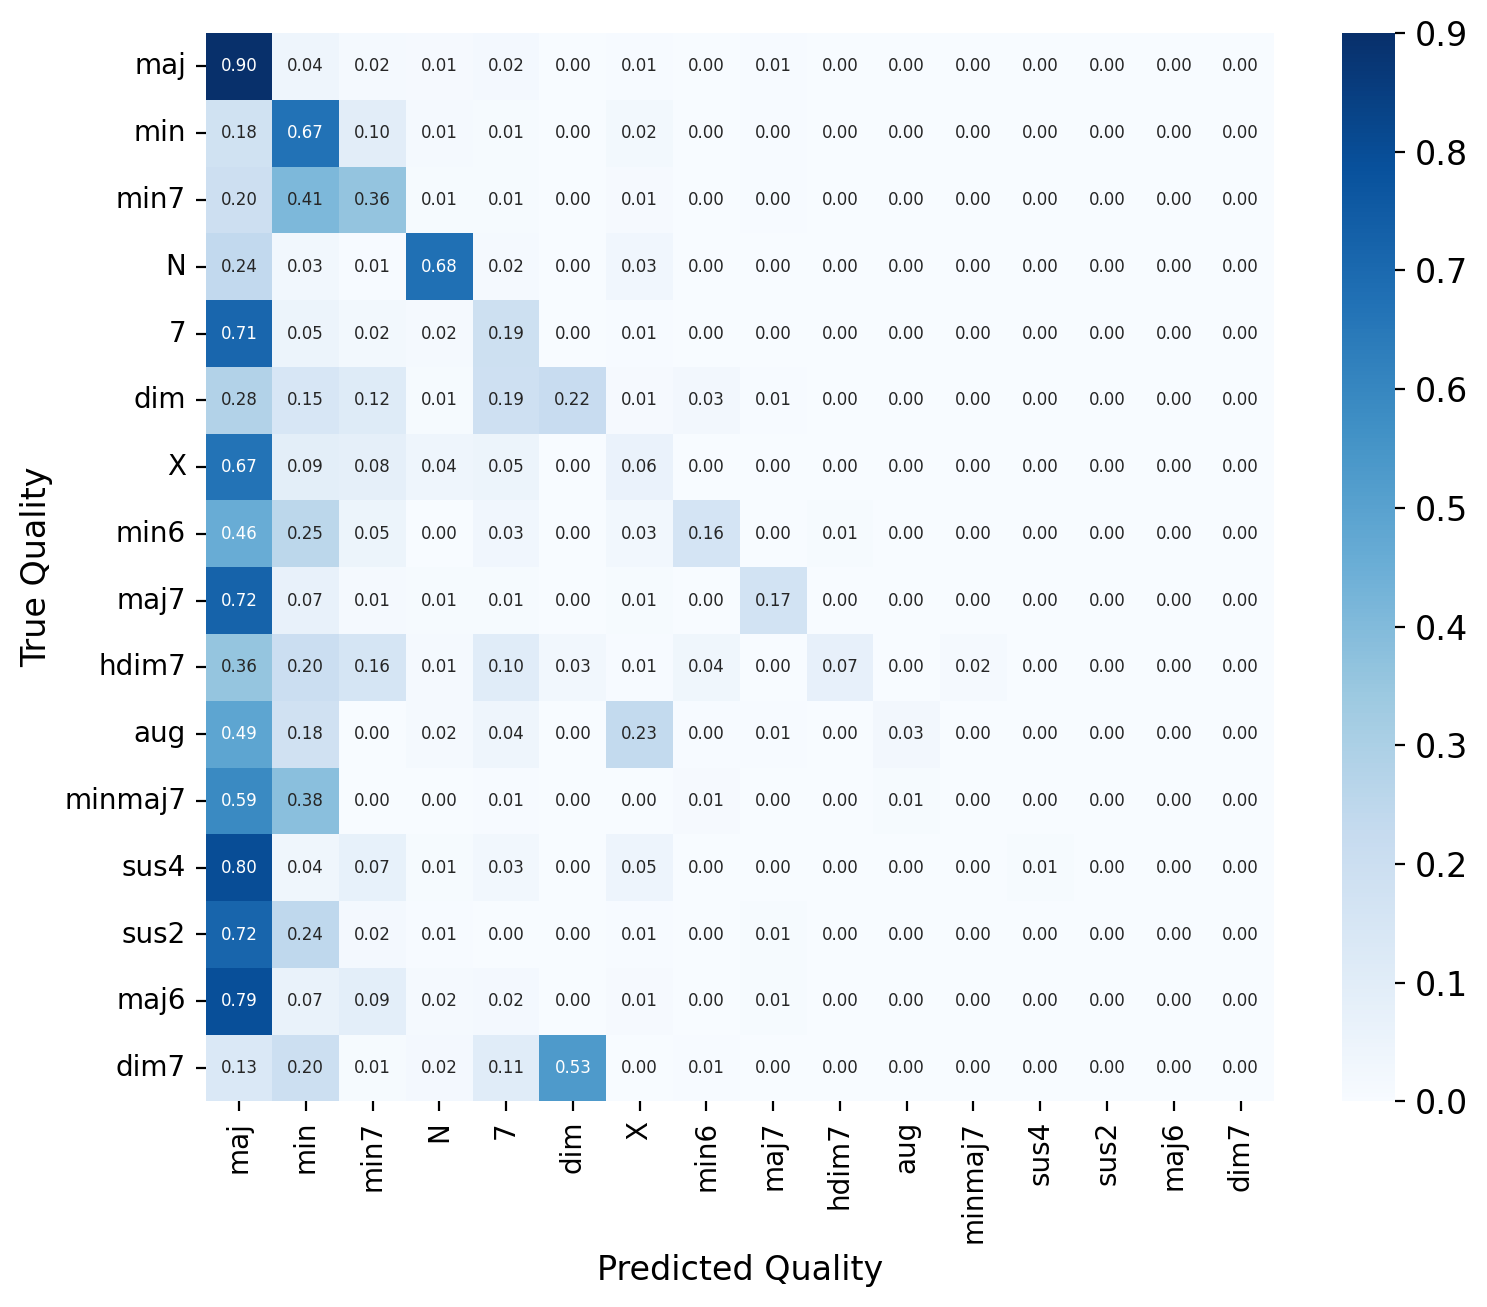

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(figsize=(8, 7))

# Plot heatmaps without colorbars
hm1 = sns.heatmap(cm_quality_normalized_reordered_real, annot=True, fmt='.2f', cmap='Blues', 
                  xticklabels=quality_labels_normalized_reordered_real, 
                  yticklabels=quality_labels_normalized_reordered_real, 
                  ax=axes, cbar=False, annot_kws={"fontsize": 6}, square=True,
                  vmin=0, vmax=0.9)
# axes[0].set_title("Confusion Matrix over Chord Qualities", fontsize=18, pad=10)
axes.set_xlabel('Predicted Quality', fontsize=12)
axes.set_ylabel('True Quality', fontsize=12)

cbar = fig.colorbar(hm1.collections[0])

# Adjust color bar limits explicitly to be 0, max of both heatmaps
cbar.set_ticks(np.linspace(0, 0.9, 10))
cbar.set_ticklabels(np.round(np.linspace(0, 0.9, 10), 1))
cbar.ax.tick_params(labelsize=12)
# Remove color bar border
cbar.outline.set_visible(False)

# Adjust layout to provide more space
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave room for the color bar
# plt.savefig('./thesis/figures/confusion_matrix_qualities.png', dpi=200, bbox_inches='tight')
plt.show()

In [29]:
DIR = './results'
experiment_name = 'synthetic_data/synthetic_and_real'

model = get_model(experiment_name)

In [31]:
all_preds_synth, all_labels_synth = get_predictions(model, dataset)

100%|██████████| 241/241 [04:04<00:00,  1.02s/it]


In [33]:
# Map chord IDs to chord qualities
all_labels_quality = [get_chord_quality(id.item()) for id in all_labels_synth]
all_preds_quality = [get_chord_quality(id.item()) for id in all_preds_synth]

# Get unique qualities and map them to indices
unique_qualities = sorted(set(all_labels_quality + all_preds_quality))
quality_to_id = {quality: i for i, quality in enumerate(unique_qualities)}
id_to_quality = {i: quality for i, quality in enumerate(unique_qualities)}

# Convert qualities to indices for confusion matrix computation
labels_quality_idx = [quality_to_id[quality] for quality in all_labels_quality]
preds_quality_idx = [quality_to_id[quality] for quality in all_preds_quality]

# Compute confusion matrix and normalized confusion matrix
cm_quality = confusion_matrix(labels_quality_idx, preds_quality_idx, labels=range(len(unique_qualities)))
cm_quality_normalized = cm_quality.astype('float') / cm_quality.sum(axis=1, keepdims=True)

# Reorder both confusion matrices by commonality of chords
order_quality = np.argsort(np.sum(cm_quality, axis=0))[::-1]
order_quality_normalized = np.argsort(np.sum(cm_quality_normalized, axis=0))[::-1]

# Reorder the confusion matrices
cm_quality_reordered_synth = cm_quality[order_quality][:, order_quality]
cm_quality_normalized_reordered_synth = cm_quality_normalized[order_quality_normalized][:, order_quality_normalized]

# Map reordered indices back to chord qualities
quality_labels_reordered_synth = [id_to_quality[id] for id in order_quality]
quality_labels_normalized_reordered_synth = [id_to_quality[id] for id in order_quality_normalized]

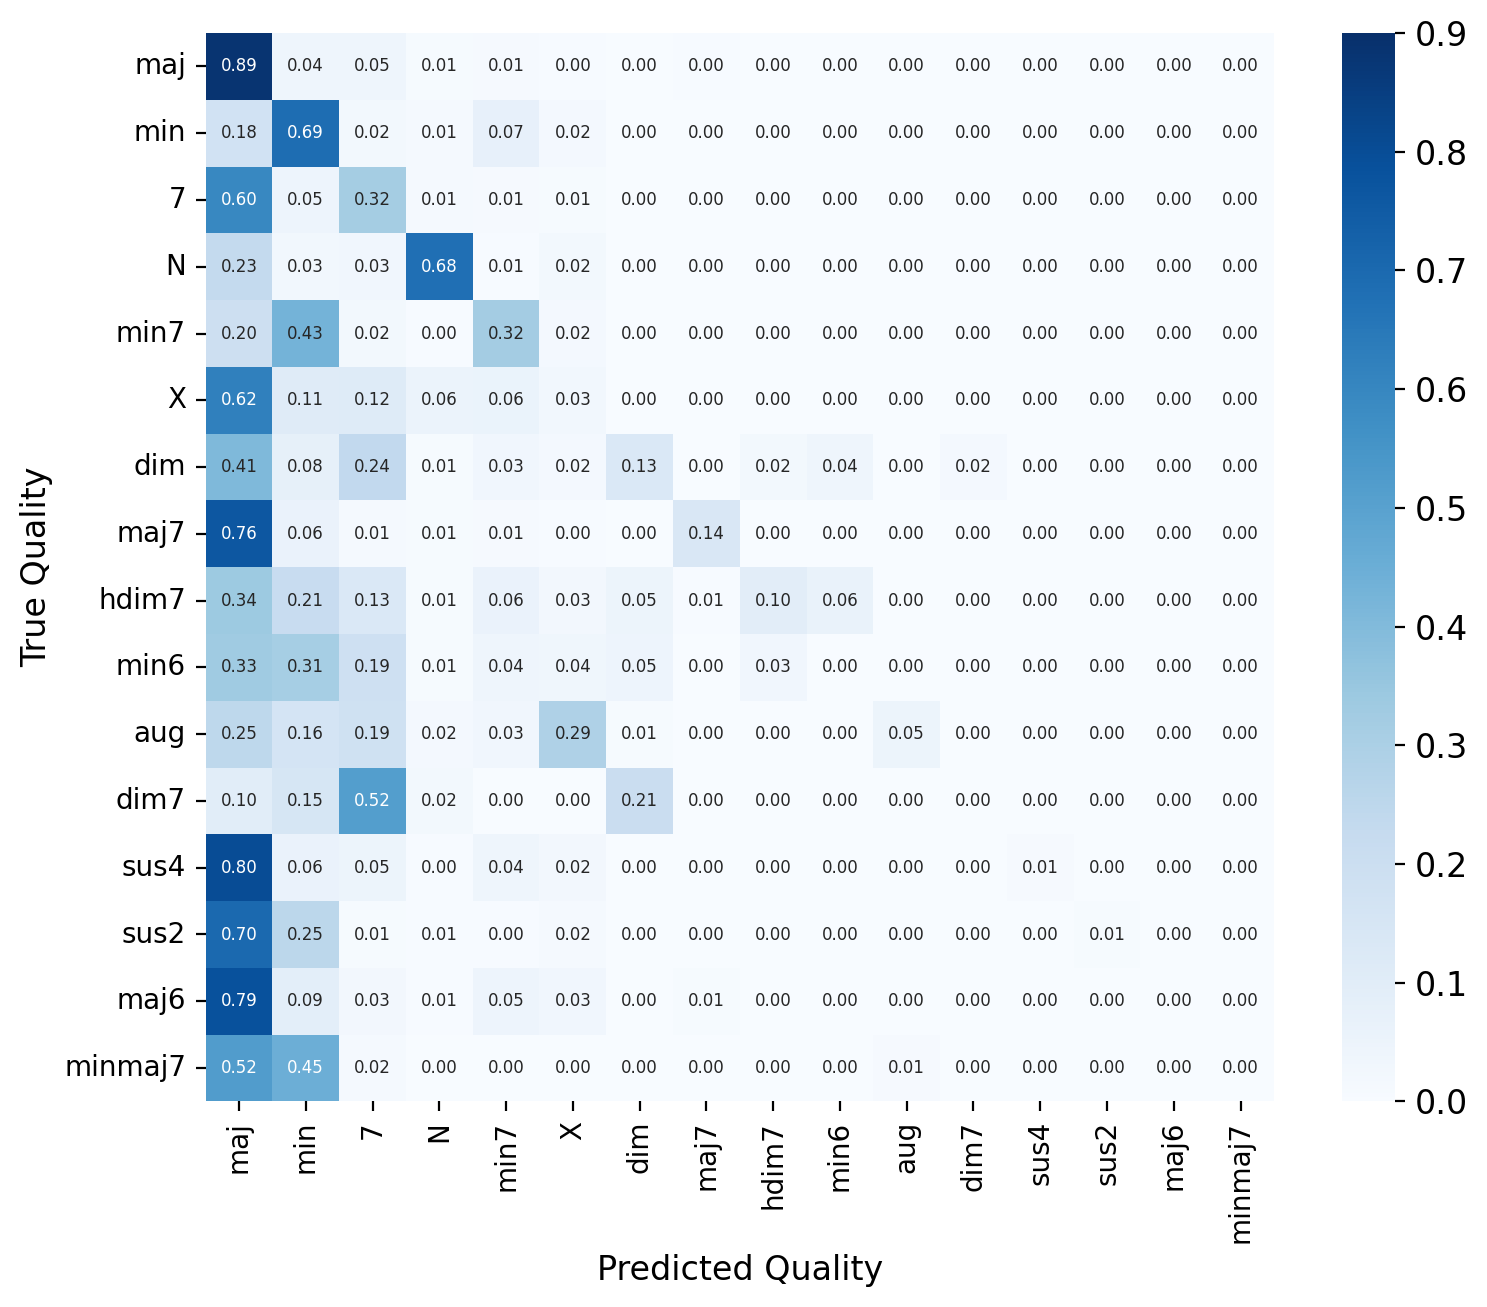

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(figsize=(8, 7))

# Plot heatmaps without colorbars
hm1 = sns.heatmap(cm_quality_normalized_reordered_synth, annot=True, fmt='.2f', cmap='Blues', 
                  xticklabels=quality_labels_normalized_reordered_synth, 
                  yticklabels=quality_labels_normalized_reordered_synth, 
                  ax=axes, cbar=False, annot_kws={"fontsize": 6}, square=True,
                  vmin=0, vmax=0.9)
# axes[0].set_title("Confusion Matrix over Chord Qualities", fontsize=18, pad=10)
axes.set_xlabel('Predicted Quality', fontsize=12)
axes.set_ylabel('True Quality', fontsize=12)

cbar = fig.colorbar(hm1.collections[0])

# Adjust color bar limits explicitly to be 0, max of both heatmaps
cbar.set_ticks(np.linspace(0, 0.9, 10))
cbar.set_ticklabels(np.round(np.linspace(0, 0.9, 10), 1))
cbar.ax.tick_params(labelsize=12)
# Remove color bar border
cbar.outline.set_visible(False)

# Adjust layout to provide more space
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave room for the color bar
# plt.savefig('./thesis/figures/confusion_matrix_qualities.png', dpi=200, bbox_inches='tight')
plt.show()

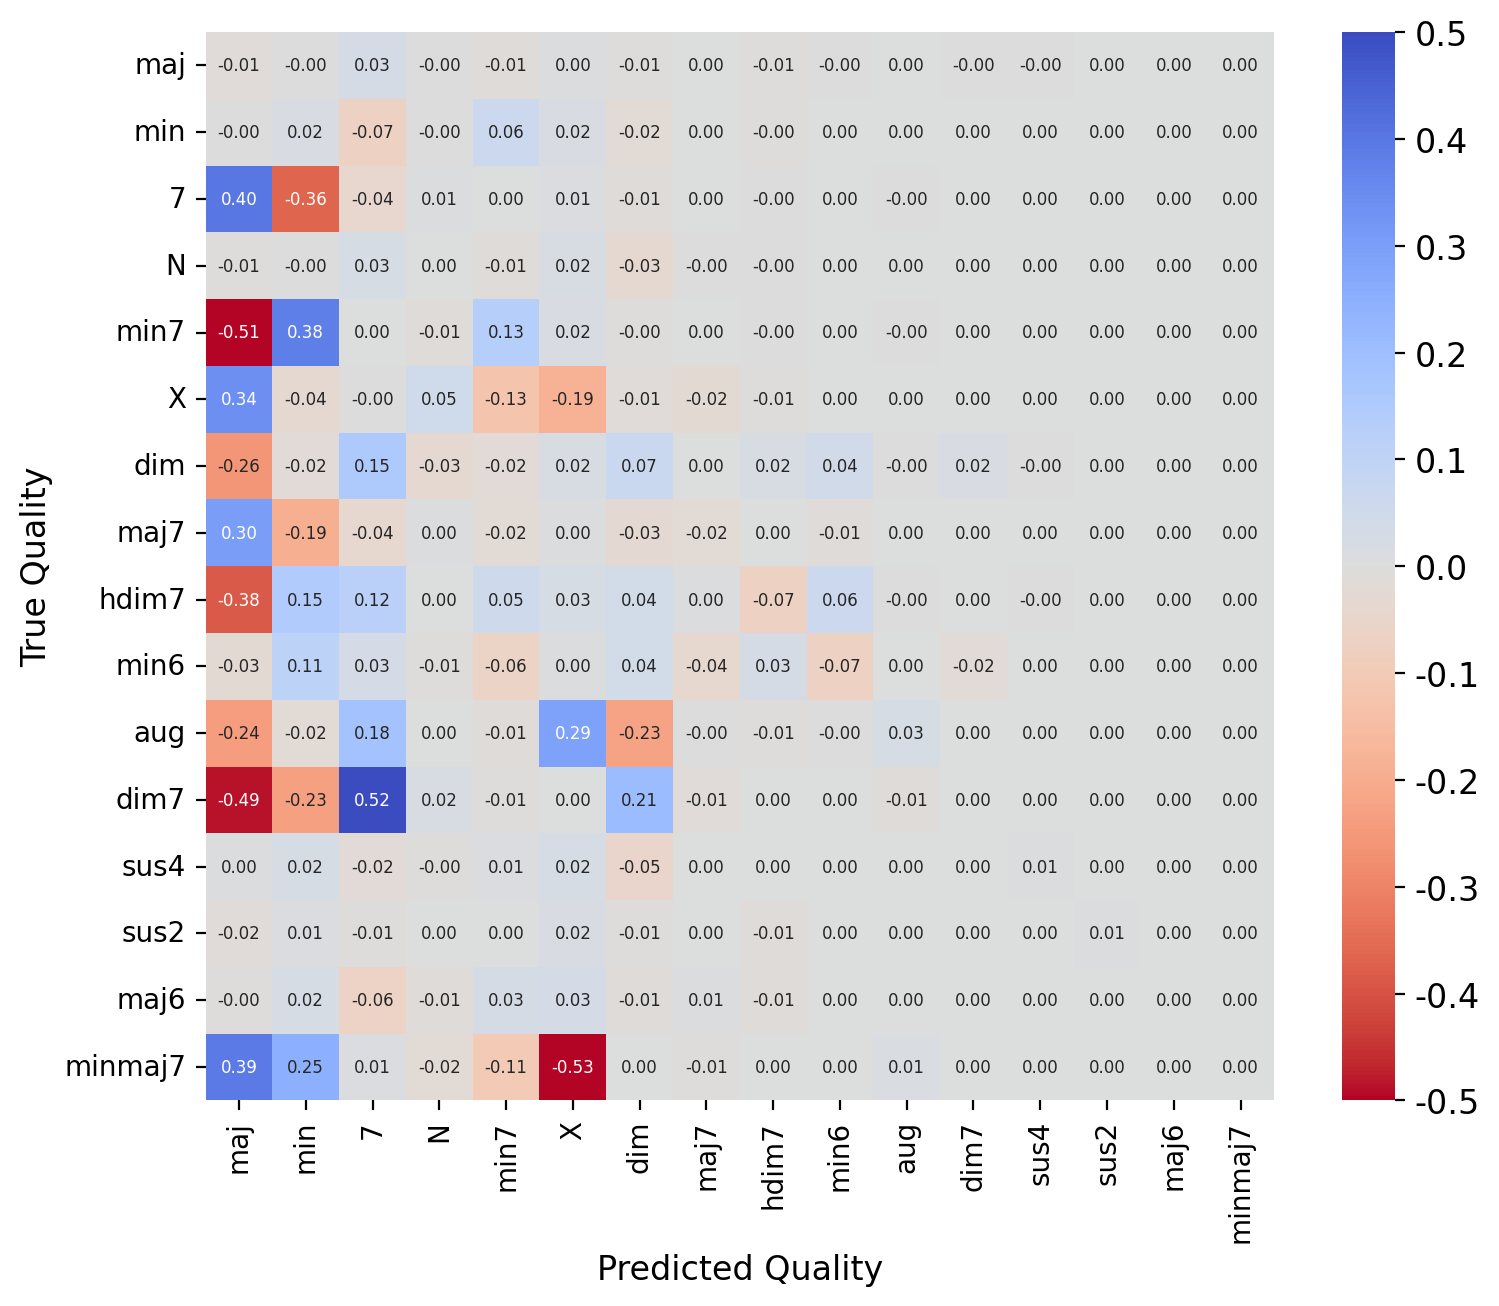

In [37]:
# Differentiate between real and synthetic data confusion matrices
diff = cm_quality_normalized_reordered_synth - cm_quality_normalized_reordered_real
fig, axes = plt.subplots(figsize=(8, 7))
# Plot heatmaps without colorbars
hm2 = sns.heatmap(diff, annot=True, fmt='.2f', cmap='coolwarm_r', 
                  xticklabels=quality_labels_normalized_reordered_synth, 
                  yticklabels=quality_labels_normalized_reordered_synth, 
                  ax=axes, cbar=False, annot_kws={"fontsize": 6}, square=True,
                  vmin=-0.5, vmax=0.5)
# axes[0].set_title("Confusion Matrix over Chord Qualities", fontsize=18, pad=10)
axes.set_xlabel('Predicted Quality', fontsize=12)
axes.set_ylabel('True Quality', fontsize=12)
cbar = fig.colorbar(hm2.collections[0])
# Adjust color bar limits explicitly to be -0.5, 0.5
cbar.set_ticks(np.linspace(-0.5, 0.5, 11))
cbar.set_ticklabels(np.round(np.linspace(-0.5, 0.5, 11), 1))
cbar.ax.tick_params(labelsize=12)
# Remove color bar border
cbar.outline.set_visible(False)
# Adjust layout to provide more space
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave room for the color bar
plt.savefig('./thesis/figures/confusion_matrix_synth.png', dpi=200, bbox_inches='tight')
plt.show()